In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys
import warnings


- [x]  Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x]  Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x]  Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [x]  Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [x]  При обучении использовать **подбор гиперпараметров**.
- [x]  Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [x]  (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [x]  (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

датасет маркетинговой кампании сети магазинов в США. Выполним сегментацию целевой аудитории, исходя из данных, полученных в результате исследования, с помощью кластеризации.

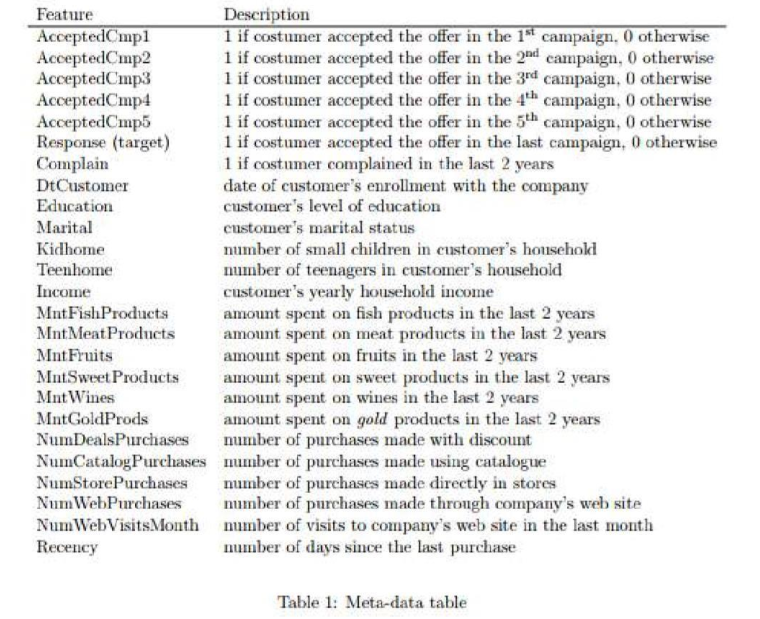

# Предобработка

In [3]:
#Загружаем данные
df = pd.read_csv("/content/marketing_campaign.csv", sep=";")
df.info()
df = df.dropna()
print("Общее количество точек данных после удаления строк с пропущенными значениями составляет:", len(df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [6]:
#переводим даты из типа объекта в тип даты
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], infer_datetime_format=True)
dates = []
for i in df["Dt_Customer"]:
   i = i.date()
   dates.append(i)

In [7]:
#Выводим даты регистраций
print("Дата регистрации последнего клиента в записях:", max(dates))
print("Самая старая дата регистрации клиента в записях:", min(dates))


Дата регистрации последнего клиента в записях: 2014-06-29
Самая старая дата регистрации клиента в записях: 2012-07-30


In [8]:
df['Marital_Status']

0         Single
1         Single
2       Together
3       Together
4        Married
          ...   
2235     Married
2236    Together
2237    Divorced
2238    Together
2239     Married
Name: Marital_Status, Length: 2216, dtype: object

In [9]:
#Создаем колонку "Cust_F"

#считаем количество дней, в течение которых клиенты начали
#совершать покупки в магазине, относительно последней зарегистрированной даты
#так мы поймем насколько холодный перед нами клиент
#и как с ним дальше взаимодействовать
days = []
d1 = max(dates) #принимаем за нового клиента
for i in dates:
    delta = d1 - i
    days.append(delta.days)
df["Cust_F"] = days
df["Cust_F"] = pd.to_numeric(df["Cust_F"], errors="coerce")

#категориальные уникальные значения
print('\t')
print("Общее количество категорий в столбце Mar_Sts:\n", df["Marital_Status"].value_counts(), "\n")
print("Всего категорий в разделе Education:\n", df["Education"].value_counts())


	
Общее количество категорий в столбце Mar_Sts:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Всего категорий в разделе Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [10]:
df['Cust_F']

0       663
1       113
2       312
3       139
4       161
       ... 
2235    381
2236     19
2237    155
2238    156
2239    622
Name: Cust_F, Length: 2216, dtype: int64

In [11]:
#Разработка функций
#Возраст клиента сегодня
df["Age"] = 2022-df["Year_Birth"]

In [12]:
df["Age"]

0       65
1       68
2       57
3       38
4       41
        ..
2235    55
2236    76
2237    41
2238    66
2239    68
Name: Age, Length: 2216, dtype: int64

In [13]:
#Общие расходы на различные предметы
df["Spent"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"]
+ df["MntGoldProds"]


0        88
1         6
2        42
3         5
4        15
       ... 
2235    247
2236      8
2237     24
2238     61
2239     21
Name: MntGoldProds, Length: 2216, dtype: int64

In [14]:
#Определение жизненного положения по семейному положению "Alone"
df["Living_With"]=df["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Alone",
                                                    "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone",})


In [15]:
df["Living_With"].describe()


count        2216
unique          2
top       Partner
freq         1430
Name: Living_With, dtype: object

In [16]:
#Характеристика, указывающая общее количество детей, проживающих в домохозяйстве
df["Children"]= df["Kidhome"] + df["Teenhome"]
df["Children"].value_counts()

1    1117
0     633
2     416
3      50
Name: Children, dtype: int64

In [17]:
#file["Age"].value_counts()

df = df[df['Age'] <= 100]

df.reset_index(inplace=True)

df["Age"]

0       65
1       68
2       57
3       38
4       41
        ..
2208    55
2209    76
2210    41
2211    66
2212    68
Name: Age, Length: 2213, dtype: int64

In [18]:
#Характеристика, указывающая общее количество детей, проживающих в домохозяйстве
df["Children"]= df["Kidhome"] + df["Teenhome"]
df["Children"].value_counts()


1    1115
0     632
2     416
3      50
Name: Children, dtype: int64

In [19]:
#Характеристика для всех членов домохозяйства
df["Living_With"] = df["Living_With"].replace({"Alone": 1, "Partner": 2})


In [20]:
df["Family_Size"] = df["Living_With"] + df["Children"]
df["Family_Size"].value_counts()

3    880
2    754
4    296
1    252
5     31
Name: Family_Size, dtype: int64

In [21]:
#Особенность относящаяся к статусу родителей
df["Is_Parent"] = np.where(df.Children > 0, 1, 0)
df["Is_Parent"].value_counts()

1    1581
0     632
Name: Is_Parent, dtype: int64

In [22]:
#Разделение уровней образования на три группы
df["Education"]=df["Education"].replace({"Basic": 0, "2n Cycle": 0, "Graduation": 1,
                                         "Master": 2, "PhD": 2})

df["Education"]

0       1
1       1
2       1
3       1
4       2
       ..
2208    1
2209    2
2210    1
2211    2
2212    2
Name: Education, Length: 2213, dtype: int64

In [23]:
#Для ясности
df = df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish",
                          "MntSweetProducts":"Sweets","MntGoldProds":"Gold"})


In [24]:
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(columns = to_drop)

In [25]:
df

,index,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,...,AcceptedCmp2,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,0,1,58138.0,0,0,58,635,88,546,172,...,0,0,1,663,65,1529,1,0,1,0
1,1,1,46344.0,1,1,38,11,1,6,2,...,0,0,0,113,68,21,1,2,3,1
2,2,1,71613.0,0,0,26,426,49,127,111,...,0,0,0,312,57,734,2,0,2,0
3,3,1,26646.0,1,0,26,11,4,20,10,...,0,0,0,139,38,48,2,1,3,1
4,4,2,58293.0,1,0,94,173,43,118,46,...,0,0,0,161,41,407,2,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,2235,1,61223.0,0,1,46,709,43,182,42,...,0,0,0,381,55,1094,2,1,3,1
2209,2236,2,64014.0,2,1,56,406,0,30,0,...,0,0,0,19,76,436,2,3,5,1
2210,2237,1,56981.0,0,0,91,908,48,217,32,...,0,0,0,155,41,1217,1,0,1,0
2211,2238,2,69245.0,0,1,8,428,30,214,80,...,0,0,0,156,66,782,2,1,3,1


In [26]:
df.columns

Index(['index', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Cust_F', 'Age', 'Spent', 'Living_With',
       'Children', 'Family_Size', 'Is_Parent'],
      dtype='object')

In [27]:
df = df.drop(columns = ['index'])

In [28]:
#  разделяю предикторы и отклики
y = df['Response']
X = df.drop(columns=['Response'])

In [29]:
#  Разделяю на обучающую и тестовую выборку

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 88)  

In [30]:
print (len(X_train.columns))
print (len(X_test.columns))

29
29


# Подбор параметров

Метод локтя для определения количества кластеров, которые должны быть сформированы:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

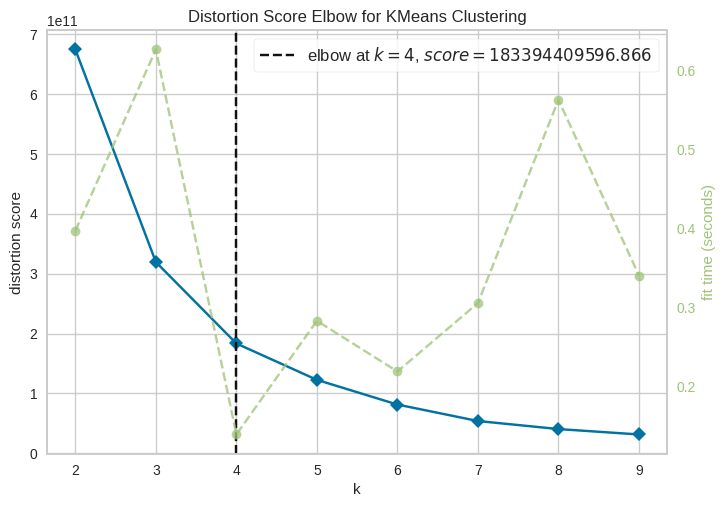

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
#метод локтя, чтобы найти количество кластеров для создания.
print('Метод локтя для определения количества кластеров, которые должны быть сформированы:')
Elbow_M = KElbowVisualizer(KMeans(), k=9)
Elbow_M.fit(df)
Elbow_M.show()

# Кластеризация 2 методами из sklearn

Иерархическая кластеризация: Аггломеративная

In [32]:
#Инициирование модели агломеративной кластеризации
AC = AgglomerativeClustering(n_clusters=4)

#подгонка модели и прогнозирование кластеров
yhat_AC = AC.fit_predict(df)
df["Clusters"] = yhat_AC

In [33]:
df["Clusters"]

0       3
1       0
2       1
3       0
4       3
       ..
2208    3
2209    1
2210    3
2211    1
2212    3
Name: Clusters, Length: 2213, dtype: int64

<Axes: >

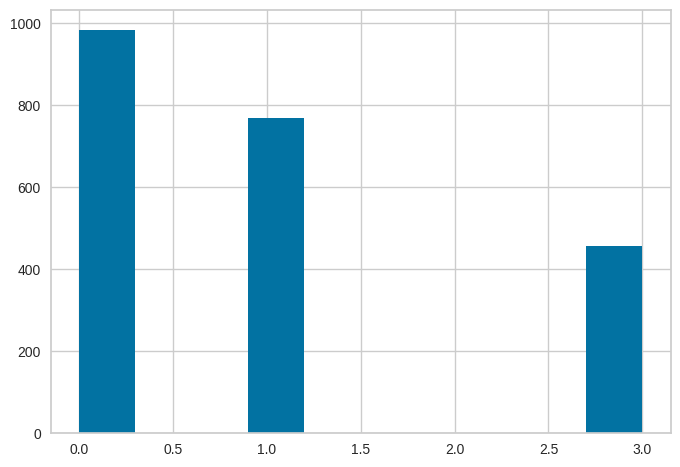

In [34]:
df["Clusters"].hist()

Кажется, я пропустила выброс... Посмотрим поближе 2-ой кластер

In [35]:
df.loc[df['Clusters'] == 2]

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Clusters
2206,1,666666.0,1,0,23,9,14,18,8,1,...,0,0,392,45,50,2,1,3,1,2


<Axes: >

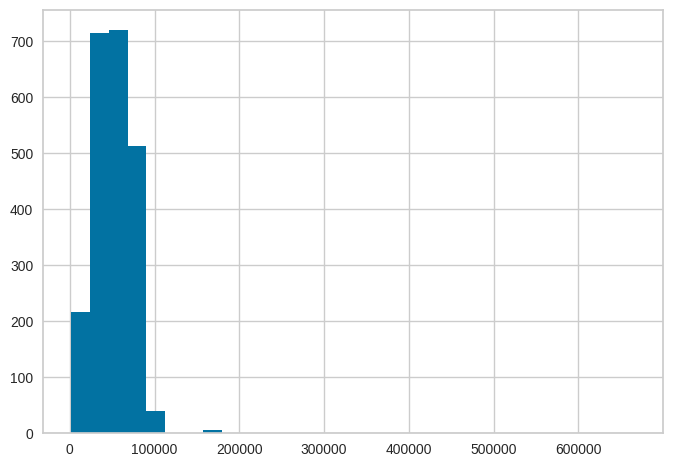

In [36]:
ax = df['Income'].hist( bins=30)
ax

Скорее всего опечатка в доходе. Удалим выброс.

In [37]:
df = df.drop(index = 2206, axis = 0)
df.tail()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Clusters
2208,1,61223.0,0,1,46,709,43,182,42,118,...,0,0,381,55,1094,2,1,3,1,3
2209,2,64014.0,2,1,56,406,0,30,0,0,...,0,0,19,76,436,2,3,5,1,1
2210,1,56981.0,0,0,91,908,48,217,32,12,...,0,0,155,41,1217,1,0,1,0,3
2211,2,69245.0,0,1,8,428,30,214,80,30,...,0,0,156,66,782,2,1,3,1,1
2212,2,52869.0,1,1,40,84,3,61,2,1,...,0,1,622,68,151,2,2,4,1,3


In [38]:
df.iloc[[2206]]

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Clusters
2207,1,34421.0,1,0,81,3,3,7,6,2,...,0,0,363,48,21,2,1,3,1,0


In [39]:
df = df.reset_index(drop = True)

In [40]:
df

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Clusters
0,1,58138.0,0,0,58,635,88,546,172,88,...,0,1,663,65,1529,1,0,1,0,3
1,1,46344.0,1,1,38,11,1,6,2,1,...,0,0,113,68,21,1,2,3,1,0
2,1,71613.0,0,0,26,426,49,127,111,21,...,0,0,312,57,734,2,0,2,0,1
3,1,26646.0,1,0,26,11,4,20,10,3,...,0,0,139,38,48,2,1,3,1,0
4,2,58293.0,1,0,94,173,43,118,46,27,...,0,0,161,41,407,2,1,3,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,1,61223.0,0,1,46,709,43,182,42,118,...,0,0,381,55,1094,2,1,3,1,3
2208,2,64014.0,2,1,56,406,0,30,0,0,...,0,0,19,76,436,2,3,5,1,1
2209,1,56981.0,0,0,91,908,48,217,32,12,...,0,0,155,41,1217,1,0,1,0,3
2210,2,69245.0,0,1,8,428,30,214,80,30,...,0,0,156,66,782,2,1,3,1,1


Метод локтя для определения количества кластеров, которые должны быть сформированы:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

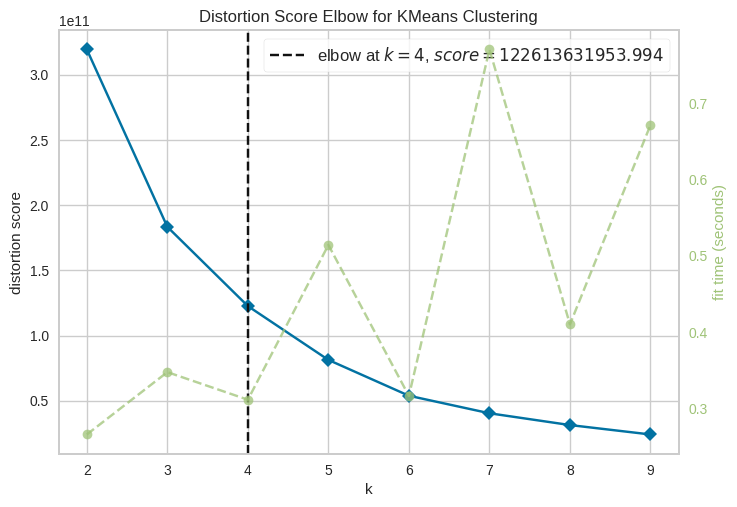

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
#метод локтя, чтобы найти количество кластеров для создания.
print('Метод локтя для определения количества кластеров, которые должны быть сформированы:')
Elbow_M = KElbowVisualizer(KMeans(), k=9)
Elbow_M.fit(df)
Elbow_M.show()

In [60]:
import time 

start = time.time() ## точка отсчета времени

#Инициирование модели агломеративной кластеризации
AC2 = AgglomerativeClustering(n_clusters=4)

#подгонка модели и прогнозирование кластеров
yhat_AC2 = AC2.fit_predict(df)
df["Clusters"] = yhat_AC2

end = time.time() - start 

Метрики: время

In [61]:
print(end)

0.3586759567260742


<Axes: >

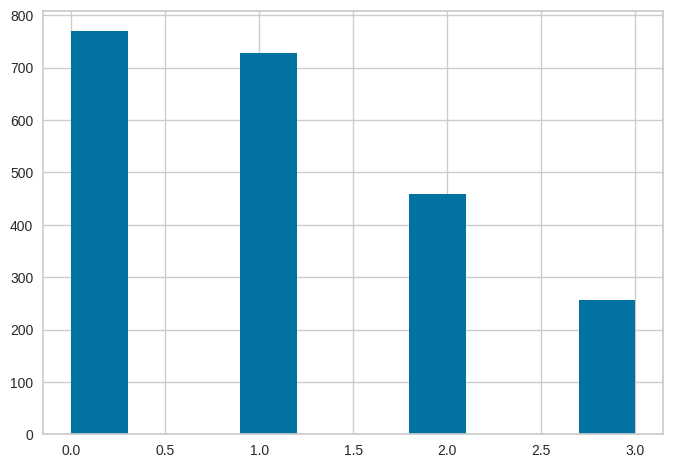

In [43]:
df["Clusters"].hist()

In [44]:
df.groupby('Clusters').mean()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent
Clusters,,,,,,,,,,,,,,,,,,,,,
0,1.315584,75476.928571,0.096104,0.401299,49.162338,608.167532,55.751948,378.066234,79.332468,57.874026,...,0.024675,0.006494,0.225974,347.954545,54.951948,1179.192208,1.645455,0.497403,2.142857,0.420779
1,1.299862,36950.876204,0.771664,0.518569,48.325997,71.287483,6.777166,35.024759,10.778542,6.770289,...,0.002751,0.012380,0.114168,347.653370,51.357634,130.638239,1.639615,1.290234,2.929849,0.899587
2,1.375546,54891.279476,0.329694,0.862445,49.155022,332.543668,19.349345,103.550218,26.965066,19.058952,...,0.019651,0.006550,0.102620,365.528384,56.661572,501.467249,1.646288,1.192140,2.838428,0.888646
3,0.844358,18724.361868,0.743191,0.147860,50.311284,11.190661,5.926070,21.284047,7.809339,6.276265,...,0.000000,0.011673,0.112840,367.062257,46.015564,52.486381,1.661479,0.891051,2.552529,0.758755


Метрики

**Посчитаем Индекс Дэвиса-Булдина**

In [63]:
for_metrics = df.drop(columns = ['Clusters', 'cluster_k'])

In [64]:
from sklearn.metrics import davies_bouldin_score

dbs = davies_bouldin_score(for_metrics, AC2.labels_)
print(dbs)


0.5450801498305151


Смотрим и понимаем, что а) есть корреляция с доходом (И ЭТО ПРАВИЛЬНО), б) есть корреляция с наличием детей (они влияют и на заработок и на траты, это тоже верно), также очевидна корреляция с алкоголем (больше на него тратятся парочки или одиночки без детей, у женатых и замужних попросту нет на него столько денег и времени, как у холостых/вдовцов и тд) 

Что-то похожее на правду, идем дальше. 

Кластеризация методом K-Means. Sklearn 

In [51]:
df

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Clusters
0,1,58138.0,0,0,58,635,88,546,172,88,...,0,1,663,65,1529,1,0,1,0,2
1,1,46344.0,1,1,38,11,1,6,2,1,...,0,0,113,68,21,1,2,3,1,1
2,1,71613.0,0,0,26,426,49,127,111,21,...,0,0,312,57,734,2,0,2,0,0
3,1,26646.0,1,0,26,11,4,20,10,3,...,0,0,139,38,48,2,1,3,1,1
4,2,58293.0,1,0,94,173,43,118,46,27,...,0,0,161,41,407,2,1,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,1,61223.0,0,1,46,709,43,182,42,118,...,0,0,381,55,1094,2,1,3,1,2
2208,2,64014.0,2,1,56,406,0,30,0,0,...,0,0,19,76,436,2,3,5,1,0
2209,1,56981.0,0,0,91,908,48,217,32,12,...,0,0,155,41,1217,1,0,1,0,2
2210,2,69245.0,0,1,8,428,30,214,80,30,...,0,0,156,66,782,2,1,3,1,0


In [52]:
df_2 = df.drop(columns = ['Clusters'])

In [53]:
df_2

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,1,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,663,65,1529,1,0,1,0
1,1,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,113,68,21,1,2,3,1
2,1,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,312,57,734,2,0,2,0
3,1,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,139,38,48,2,1,3,1
4,2,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,161,41,407,2,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,1,61223.0,0,1,46,709,43,182,42,118,...,0,0,0,381,55,1094,2,1,3,1
2208,2,64014.0,2,1,56,406,0,30,0,0,...,0,0,0,19,76,436,2,3,5,1
2209,1,56981.0,0,0,91,908,48,217,32,12,...,0,0,0,155,41,1217,1,0,1,0
2210,2,69245.0,0,1,8,428,30,214,80,30,...,0,0,0,156,66,782,2,1,3,1


In [54]:
import time 

start = time.time()

model2 = KMeans(n_clusters=4, random_state=42)
model2.fit(df_2)
df['cluster_k'] = model2.labels_
df.groupby('cluster_k').mean()


end = time.time() - start 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Метрики

In [55]:
print(end)

0.5857033729553223


Здесь разбивка по кластерам очень похожая, тоже корреляция с доходом и детьми.

<Axes: >

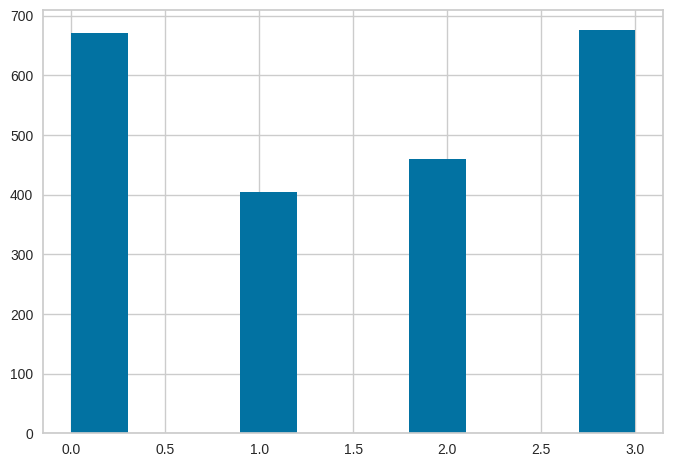

In [56]:
df["cluster_k"].hist()

In [65]:
from sklearn.metrics import davies_bouldin_score

dbs = davies_bouldin_score(for_metrics, df['cluster_k'])
print(dbs)

0.5663829467313946


# Своя реализация: 

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random

def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))


class KMeans_:
    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X_train):
        #X_train = list(X_train)
        self.centroids = [random.choice(X_train)]
       
        for _ in range(self.n_clusters-1):
            
            dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            
            dists /= np.sum(dists)
            
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs

In [58]:
df_3 = df.drop(columns = ['cluster_k','Clusters'])

In [102]:
df_3

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,1,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,663,65,1529,1,0,1,0
1,1,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,113,68,21,1,2,3,1
2,1,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,312,57,734,2,0,2,0
3,1,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,139,38,48,2,1,3,1
4,2,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,161,41,407,2,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,1,61223.0,0,1,46,709,43,182,42,118,...,0,0,0,381,55,1094,2,1,3,1
2208,2,64014.0,2,1,56,406,0,30,0,0,...,0,0,0,19,76,436,2,3,5,1
2209,1,56981.0,0,0,91,908,48,217,32,12,...,0,0,0,155,41,1217,1,0,1,0
2210,2,69245.0,0,1,8,428,30,214,80,30,...,0,0,0,156,66,782,2,1,3,1


In [103]:
model3 = KMeans_(n_clusters=4)

In [109]:
import time 

start = time.time()

model3.fit(df_3.to_numpy())
cluster_centers, labels = model3.evaluate(df_3.to_numpy())


end = time.time() - start 

Метрики

In [107]:

print(end) ## вывод времени

0.8592307567596436


# Уменьшение размерности

3 компоненты: 

In [71]:
df_pca = df.drop(columns = ['Clusters', 'cluster_k'])

In [72]:
scaler = StandardScaler()

scaled_ds = scaler.fit_transform(df_pca[df_pca.columns])

print(np.argwhere(np.isnan(scaled_ds)))

[]


In [73]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["column1","column2", "column3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
column1,2212.0,1.092154e-16,2.957916,-5.891776,-2.553594,-0.870292,2.257096,8.563655
column2,2212.0,-9.636656e-17,1.724631,-4.249311,-1.339582,-0.146408,1.237662,6.195212
column3,2212.0,-6.424437e-17,1.392258,-3.338873,-0.772187,-0.155809,0.381388,8.543910


In [74]:
PCA_ds

,column1,column2,column3
0,4.901989,-0.412814,0.104082
1,-2.955330,-0.040512,-0.314355
2,2.346038,-0.837128,-1.190401
3,-2.735217,-1.559032,-0.013563
4,-0.754378,0.305516,-0.679880
...,...,...,...
2207,1.952106,2.129251,-1.355740
2208,-2.502865,4.155250,1.111328
2209,2.730602,-1.469539,0.959054
2210,1.298634,1.808076,-1.322636


In [75]:
#3D-Проекция данных в уменьшенном размере
x =PCA_ds["column1"]
y =PCA_ds["column2"]
z =PCA_ds["column3"]

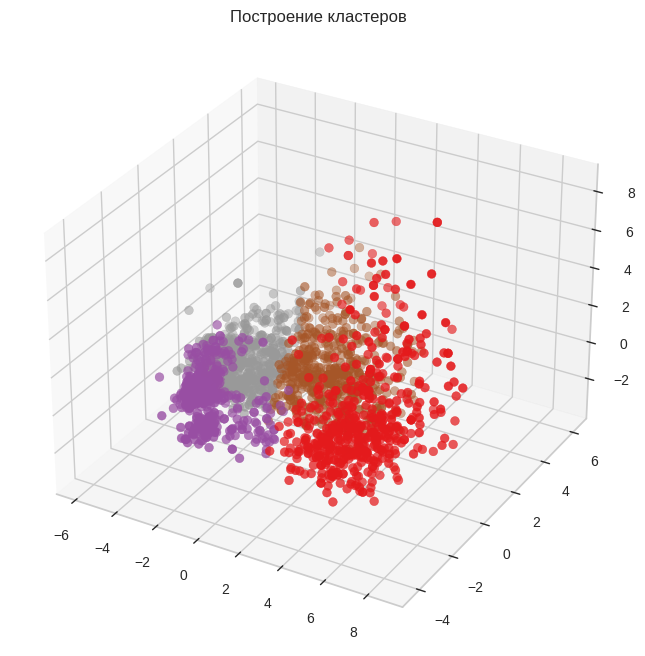

In [88]:
#Инициирование модели агломеративной кластеризации
AC_PCA = AgglomerativeClustering(n_clusters=4)

start = time.time()
#подгонка модели и прогнозирование кластеров
yhat_AC_PCA = AC_PCA.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC_PCA
end = time.time() - start 
#Добавление функции кластеров в исходный фрейм данных
df["Clusters_AC_PCA"]= yhat_AC_PCA

color = ['lightcoral', 'darkorange', 'olive', 'teal', 'violet', 
         'skyblue']

#Построение графиков кластеров
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], cmap='Set1')
ax.set_title("Построение кластеров")
plt.show()

Метрики

In [89]:
print(end)

0.18939852714538574


In [97]:
PCA_ds.columns

Index(['column1', 'column2', 'column3', 'Clusters', 'Clusters_KM'], dtype='object')

In [98]:
for_metrics_2 = PCA_ds.drop(columns = [ 'Clusters', 'Clusters_KM'])

In [100]:

from sklearn.metrics import davies_bouldin_score

dbs = davies_bouldin_score(for_metrics_2, df["Clusters_AC_PCA"])
print(dbs)


1.0221977403943279


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


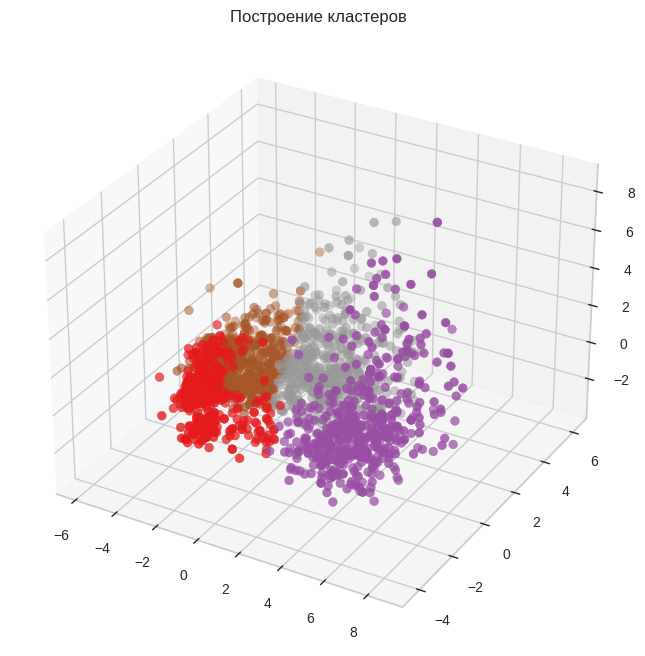

In [90]:
#Инициирование модели агломеративной кластеризации
KM = KMeans(n_clusters=4)

start = time.time()
#подгонка модели и прогнозирование кластеров
yhat_KM = KM.fit_predict(PCA_ds)
PCA_ds["Clusters_KM"] = yhat_KM
end = time.time() - start 
#Добавление функции кластеров в исходный фрейм данных
df["Clusters_KM"]= yhat_KM

color = ['lightcoral', 'darkorange', 'olive', 'teal', 'violet', 
         'skyblue']

#Построение графиков кластеров
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters_KM"], cmap='Set1')
ax.set_title("Построение кластеров")
plt.show()

In [91]:
print(end)

0.3518681526184082


In [119]:
PCA_ds = PCA_ds.drop(columns = ['Clusters3'])

In [120]:
PCA_ds.columns


Index(['column1', 'column2', 'column3', 'Clusters', 'Clusters_KM'], dtype='object')

In [122]:
#Инициирование модели агломеративной кластеризации
my_KM = KMeans_(n_clusters=4)

start = time.time()
#подгонка модели и прогнозирование кластеров
my_KM.fit(PCA_ds.drop(columns = ['Clusters', 'Clusters_KM']).to_numpy())

cluster_centers, labels = my_KM.evaluate(PCA_ds.drop(columns = ['Clusters', 'Clusters_KM']).to_numpy())

PCA_ds["Clusters3"] = labels
end = time.time() - start 


Метрики

In [123]:
print(end)

0.5894508361816406


In [124]:
for_metrics_3 = PCA_ds.drop(columns = [ 'Clusters', 'Clusters_KM','Clusters3'])

In [126]:
from sklearn.metrics import davies_bouldin_score

dbs = davies_bouldin_score(for_metrics_3, PCA_ds['Clusters3'])
print(dbs)


0.9990474025305011


4 компоненты:

In [130]:
df_pca

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Cust_F,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,1,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,663,65,1529,1,0,1,0
1,1,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,113,68,21,1,2,3,1
2,1,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,312,57,734,2,0,2,0
3,1,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,139,38,48,2,1,3,1
4,2,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,161,41,407,2,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,1,61223.0,0,1,46,709,43,182,42,118,...,0,0,0,381,55,1094,2,1,3,1
2208,2,64014.0,2,1,56,406,0,30,0,0,...,0,0,0,19,76,436,2,3,5,1
2209,1,56981.0,0,0,91,908,48,217,32,12,...,0,0,0,155,41,1217,1,0,1,0
2210,2,69245.0,0,1,8,428,30,214,80,30,...,0,0,0,156,66,782,2,1,3,1


In [131]:
scaler = StandardScaler()

scaled_ds = scaler.fit_transform(df_pca[df_pca.columns])

print(np.argwhere(np.isnan(scaled_ds)))

[]


In [132]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["column1","column2", "column3","column4"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
column1,2212.0,-7.066881e-17,2.957916,-5.891769,-2.553595,-0.870289,2.257096,8.563656
column2,2212.0,3.212219e-17,1.724633,-4.246354,-1.336930,-0.145599,1.239454,6.195268
column3,2212.0,1.606109e-18,1.392321,-3.323793,-0.771213,-0.157607,0.381548,8.535707
column4,2212.0,-9.636656e-18,1.292972,-4.382098,-0.861877,-0.053666,0.887737,5.132176


In [133]:
PCA_ds

,column1,column2,column3,column4
0,4.901986,-0.410911,0.122933,3.048827
1,-2.955332,-0.039927,-0.315159,-1.333075
2,2.346039,-0.834706,-1.175846,-0.109920
3,-2.735215,-1.557879,-0.005443,-0.220097
4,-0.754378,0.305382,-0.681948,-0.194305
...,...,...,...,...
2207,1.952104,2.129710,-1.339945,1.328594
2208,-2.502869,4.162469,1.127030,-1.640873
2209,2.730606,-1.472596,0.945467,-1.017365
2210,1.298635,1.809816,-1.312369,-1.488001


In [135]:
#Инициирование модели агломеративной кластеризации
AC_PCA = AgglomerativeClustering(n_clusters=4)

start = time.time()
#подгонка модели и прогнозирование кластеров
yhat_AC_PCA = AC_PCA.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC_PCA
end = time.time() - start 
#Добавление функции кластеров в исходный фрейм данных
df["Clusters_AC_PCA"]= yhat_AC_PCA


print(end)

0.3466761112213135


In [136]:
PCA_ds.columns

Index(['column1', 'column2', 'column3', 'column4', 'Clusters'], dtype='object')

In [137]:
for_metrics_2 = PCA_ds.drop(columns = [ 'Clusters'])
from sklearn.metrics import davies_bouldin_score

dbs = davies_bouldin_score(for_metrics_2, df["Clusters_AC_PCA"])
print(dbs)


1.2550526669194042


In [138]:
#Инициирование модели агломеративной кластеризации
KM = KMeans(n_clusters=4)

start = time.time()
#подгонка модели и прогнозирование кластеров
yhat_KM = KM.fit_predict(PCA_ds)
PCA_ds["Clusters_KM"] = yhat_KM
end = time.time() - start 
#Добавление функции кластеров в исходный фрейм данных
df["Clusters_KM"]= yhat_KM

print(end)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.3972959518432617


In [139]:
PCA_ds.columns

Index(['column1', 'column2', 'column3', 'column4', 'Clusters', 'Clusters_KM'], dtype='object')

In [144]:
for_metrics_3 = PCA_ds.drop(columns = ['Clusters', 'Clusters_KM'])
from sklearn.metrics import davies_bouldin_score

dbs = davies_bouldin_score(for_metrics_3, PCA_ds['Clusters_KM'])
print(dbs)

1.0455102355884518


In [141]:
#Инициирование модели агломеративной кластеризации
my_KM = KMeans_(n_clusters=4)

start = time.time()
#подгонка модели и прогнозирование кластеров
my_KM.fit(PCA_ds.drop(columns = ['Clusters', 'Clusters_KM']).to_numpy())

cluster_centers, labels = my_KM.evaluate(PCA_ds.drop(columns = ['Clusters', 'Clusters_KM']).to_numpy())

PCA_ds["Clusters_myKM"] = labels
end = time.time() - start 

In [142]:
print(end)

0.5890846252441406


In [143]:
PCA_ds.columns

Index(['column1', 'column2', 'column3', 'column4', 'Clusters', 'Clusters_KM',
       'Clusters_myKM'],
      dtype='object')

In [145]:
for_metrics_4 = PCA_ds.drop(columns = ['Clusters', 'Clusters_KM','Clusters_myKM'])
from sklearn.metrics import davies_bouldin_score

dbs = davies_bouldin_score(for_metrics_4, PCA_ds['Clusters_myKM'])
print(dbs)

1.1679533069042005


# Визуализация 

PCA 3 comp 

In [147]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["column1","column2", "column3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
column1,2212.0,-2.569775e-17,2.957916,-5.891767,-2.553595,-0.870289,2.257095,8.563647
column2,2212.0,-1.798842e-16,1.724633,-4.246779,-1.337971,-0.145361,1.238698,6.194928
column3,2212.0,1.365193e-17,1.392319,-3.330240,-0.772477,-0.159558,0.379264,8.529986


In [148]:
PCA_ds

,column1,column2,column3
0,4.901991,-0.411773,0.124038
1,-2.955330,-0.040800,-0.317350
2,2.346038,-0.834281,-1.175735
3,-2.735217,-1.557144,-0.006604
4,-0.754380,0.306430,-0.683165
...,...,...,...
2207,1.952110,2.129969,-1.342330
2208,-2.502868,4.160950,1.122035
2209,2.730602,-1.470949,0.950068
2210,1.298635,1.809913,-1.311790


CPU times: user 30.3 s, sys: 54.4 ms, total: 30.4 s
Wall time: 17.9 s


<timed exec>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


Text(0.5, 1.0, 'Covertype dataset. t-SNE projection')

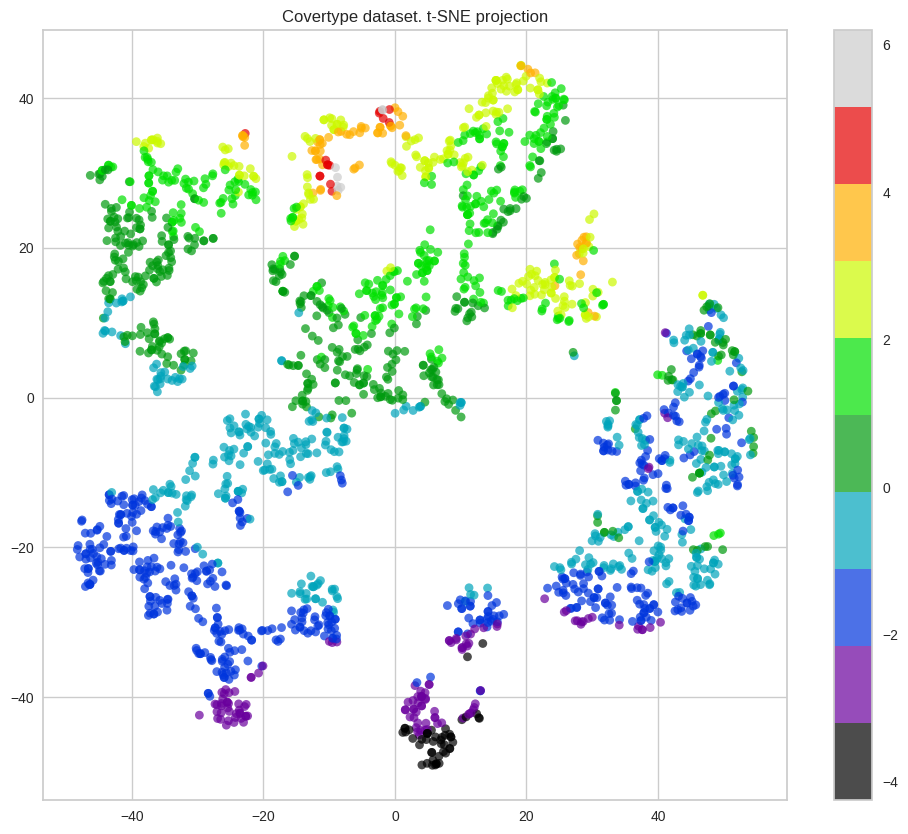

In [149]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)


X_tsne = tsne.fit_transform(PCA_ds)

plt.figure(figsize=(12, 10))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("Covertype dataset. t-SNE projection");

<ipython-input-152-48ab1354884a>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("nipy_spectral", 10),


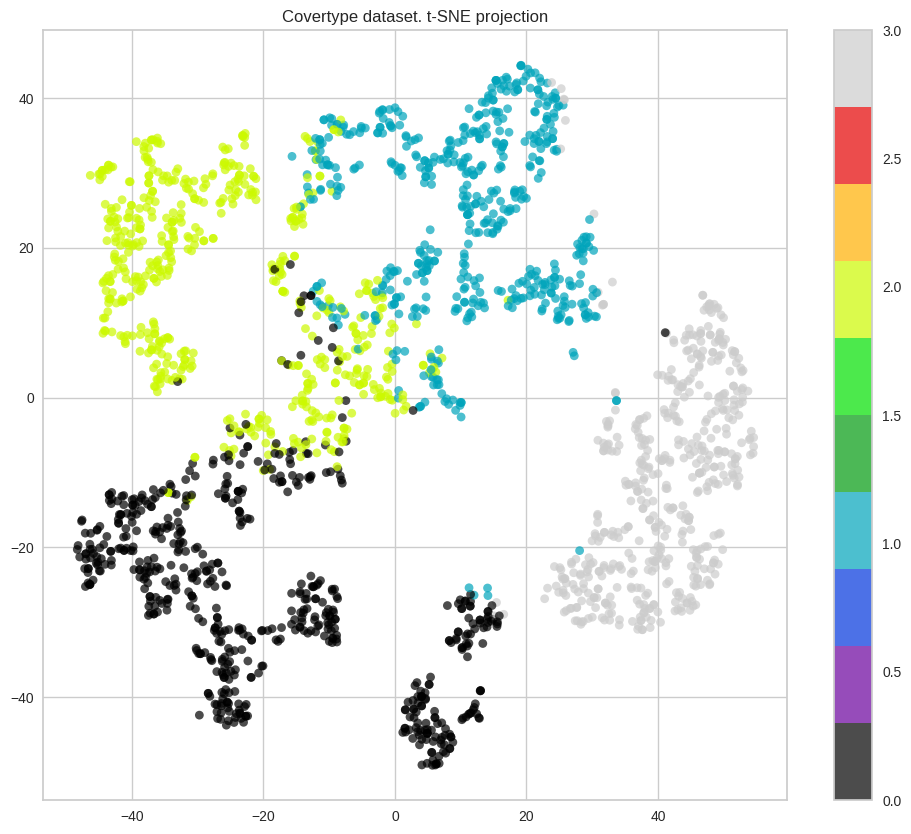

In [152]:
plt.figure(figsize=(12, 10))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=labels,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("Covertype dataset. t-SNE projection");

Метрики: 

скорость обучения:

PCA: 
KMeans: 0.351
Agglomerative: 0.189
My_Kmeans: 0.589

На входных данных: 
KMeans: 0.5857
Agglomerative: 0.358
My_Kmeans: 0.85


индекс Дэвиса-Булдина:
PCA: 
KMeans: 0.99
Agglomerative: 1.02
My_Kmeans: 0.99

На входных данных: 
KMeans: 0.566
Agglomerative: 0.54
My_Kmeans: 
